# 🔍 Exploratory Data Analysis (EDA) – SmartSort-CAM Project
Welcome to the EDA notebook for our synthetic industrial parts dataset.
This notebook includes:
- Dataset distribution
- Render sanity checks
- Image dimension checks
- Label verification
- Sample visualization
- Augmentation previews
- Trained model prediction sanity check
- Domain Shift Trained Model Performance Check

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
import torch
import timm

%matplotlib inline
sns.set(style="whitegrid")


In [3]:
df = pd.read_csv("VisionInspect/data/part_labels.csv")
print(f"Total samples: {len(df)}")
df.head()


Total samples: 3400


,filepath,label
0,bolt/good/bolt_bolta_good_000.png,bolt
1,bolt/good/bolt_bolta_good_001.png,bolt
2,bolt/good/bolt_bolta_good_002.png,bolt
3,bolt/good/bolt_bolta_good_003.png,bolt
4,bolt/good/bolt_bolta_good_004.png,bolt


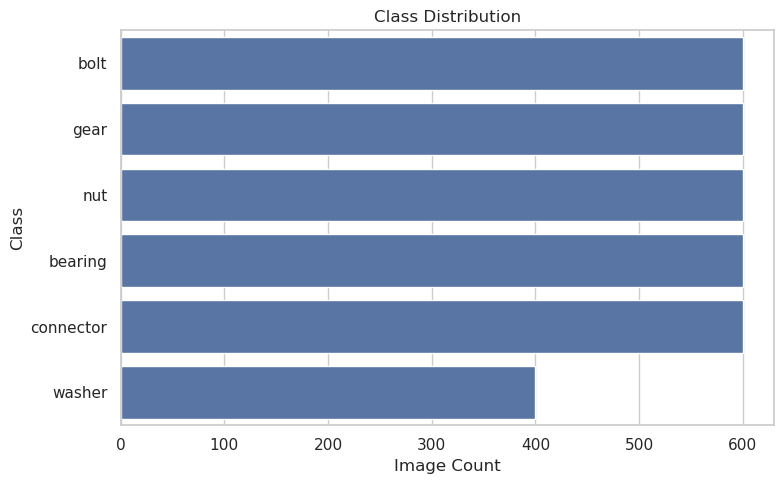

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title("Class Distribution")
plt.xlabel("Image Count")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


In [5]:
missing_files = [f for f in df['filepath'] if not os.path.exists(os.path.join("data", f))]
print(f"Missing or corrupt files: {len(missing_files)}")
assert len(missing_files) == 0, "Some files are missing! Fix your dataset before training."


Missing or corrupt files: 0


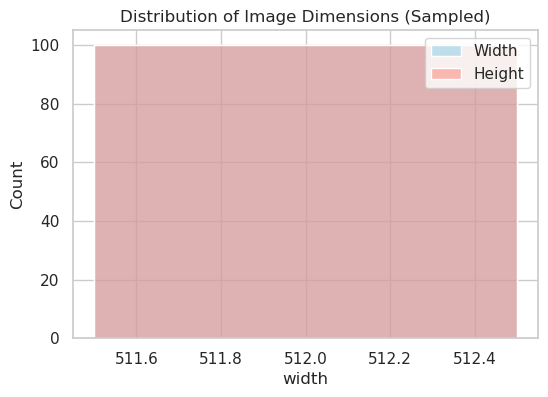

In [6]:
img_shapes = []
for path in df['filepath'].sample(100):  # Sample for speed
    with Image.open(os.path.join("data", path)) as img:
        img_shapes.append(img.size)

shape_df = pd.DataFrame(img_shapes, columns=['width', 'height'])
plt.figure(figsize=(6, 4))
sns.histplot(shape_df['width'], kde=True, color="skyblue", label='Width')
sns.histplot(shape_df['height'], kde=True, color="salmon", label='Height')
plt.title("Distribution of Image Dimensions (Sampled)")
plt.legend()
plt.show()


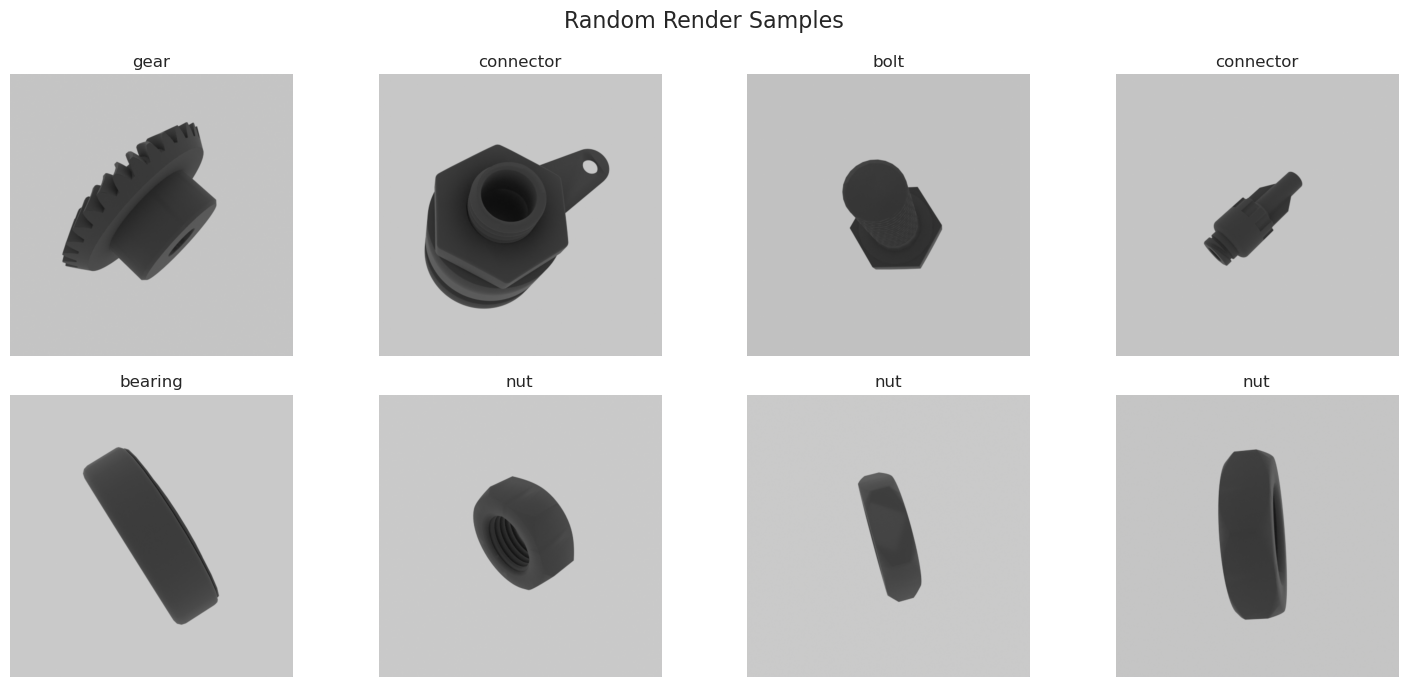

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for ax in axs.ravel():
    sample = df.sample(1).iloc[0]
    img_path = os.path.join("data", sample['filepath'])
    label = sample['label']
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)
plt.suptitle("Random Render Samples", fontsize=16)
plt.tight_layout()
plt.show()


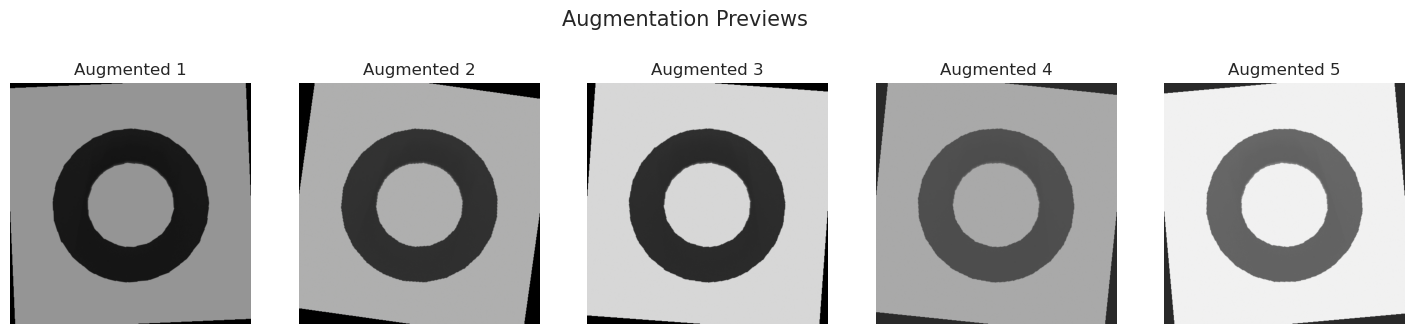

In [8]:
transform_aug = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor()
])

fig, axs = plt.subplots(1, 5, figsize=(18, 4))
sample_path = os.path.join("data", df.sample(1).iloc[0]['filepath'])
img = Image.open(sample_path).convert("RGB")

for i in range(5):
    augmented = transform_aug(img)
    axs[i].imshow(np.transpose(augmented.numpy(), (1, 2, 0)))
    axs[i].axis("off")
    axs[i].set_title(f"Augmented {i+1}")
plt.suptitle("Augmentation Previews", fontsize=15)
plt.show()


In [13]:
# Convert to RGB
if img.mode == 'RGBA' or img.mode == 'P': # Handle RGBA and Palette images
    print(f"Converting image from mode {img.mode} to RGB...")
    img = img.convert('RGB')
elif img.mode != 'RGB':
    print(f"Warning: Image mode is {img.mode}. Converting to RGB.")
    img = img.convert('RGB')


model = timm.create_model("convnext_base", pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

img = preprocess(img).unsqueeze(0)
with torch.no_grad():
    logits = model(img)
print("Logits:", logits[0][:6], "...")  # Display first 5 class logits


Converting image from mode RGBA to RGB...
Logits: tensor([-0.8149, -0.5775, -1.1134, -0.3797, -0.1160]) ...


In [31]:
#Sanity - Overlap Check
import pandas as pd
#from train_classifier import PartDataset  # Assuming same file or shared environment

# Load CSV again
df = pd.read_csv(CSV_PATH)
PartDataset.prepare_class_index_map(['bolt', 'gear', 'nut', 'washer', 'bearing', 'connector'])

# Recreate full dataset with index mapping
full_dataset = PartDataset(CSV_PATH, "data")
val_size = int(len(full_dataset) * 0.2)
train_size = len(full_dataset) - val_size

from torch.utils.data import random_split
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Extract paths from indices (match CSV paths)
train_paths = set(df.iloc[train_dataset.indices]['filepath'].values)
val_paths = set(df.iloc[val_dataset.indices]['filepath'].values)

# Check overlap
overlapping_paths = train_paths.intersection(val_paths)
print(f"Number of overlapping file paths in train and validation sets: {len(overlapping_paths)}")
if overlapping_paths:
    print("Overlap detected! Examples:")
    for i, path in enumerate(list(overlapping_paths)[:10]):
        print(f" - {path}")
else:
    print("No overlap. Train/Validation split is clean.")


🔍 Number of overlapping file paths in train and validation sets: 0
✅ No overlap. Train/Validation split is clean.


/w0/tmp/slurm_kt226005.56165959/ipykernel_805/2202229213.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/rwthfs/rz/cluster/home/kt2260

🔄 Domain Shift Accuracy: 99.50%
🔮 Avg Prediction Confidence: 0.9704


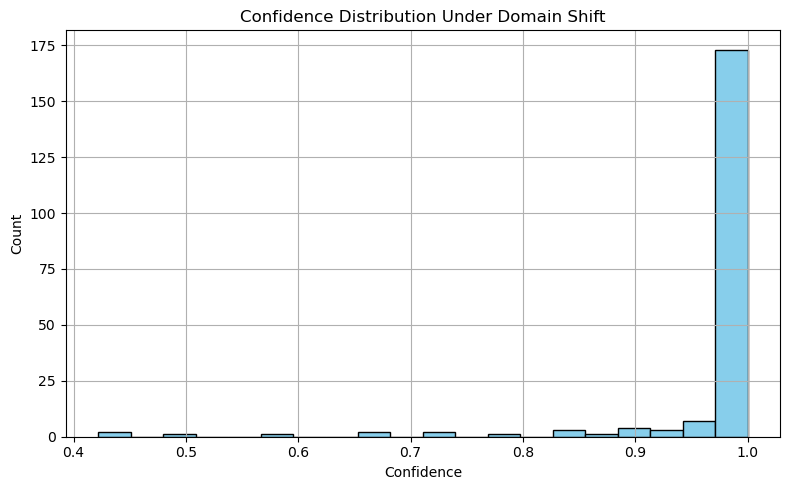

In [36]:
#Domain Shift Model Performance Check
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# === LOAD MODEL ===
model = timm.create_model('convnext_large', pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("/VisionInspect/models/convnext_large.pth", map_location=DEVICE))
model.eval().to(DEVICE)

# === CLASS INDEX ===
class_names = ['bolt', 'gear', 'nut', 'washer', 'bearing', 'connector']
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# === DOMAIN SHIFT TRANSFORMS ===
# Simulate low-light, blur, and pose (rotation)
def domain_shift(img: Image.Image) -> Image.Image:
    img = img.convert("RGB")
    img = ImageEnhance.Brightness(img).enhance(0.5)  # simulate low light
    img = img.rotate(20)  # slight rotational change
    img = img.filter(ImageFilter.GaussianBlur(radius=1.5))  # blur
    return img

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === EVALUATE ON SHIFTED IMAGES ===
df = pd.read_csv(CSV_PATH)
correct = 0
total = 0
confidences = []
predictions = []
truths = []

sample_paths = df.sample(200, random_state=42).reset_index(drop=True)  # Test on subset

for _, row in tqdm(sample_paths.iterrows(), total=len(sample_paths)):
    path = os.path.join(DATA_ROOT, row['filepath'])
    label = class_to_idx[row['label']]
    
    try:
        img = Image.open(path)
        shifted_img = domain_shift(img)
        input_tensor = transform(shifted_img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
            conf = torch.softmax(output, dim=1)[0, pred].item()

        correct += (pred == label)
        confidences.append(conf)
        predictions.append(pred)
        truths.append(label)
        total += 1
    except:
        continue

accuracy = correct / total
avg_conf = np.mean(confidences)

print(f"Domain Shift Accuracy: {accuracy*100:.2f}%")
print(f"Avg Prediction Confidence: {avg_conf:.4f}")

# === PLOT CONFIDENCE HISTOGRAM ===
plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Confidence Distribution Under Domain Shift")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()
